In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import gensim
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab 
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 56.0 MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-py3-none-any.whl size=829180942 sha256=fc2cc76a3d2713876a7c5133c00103b92e8de5801cbb3a96e79902963b3172a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-e97i3pde/wheels/11/95/ba/2c36cc368c0bd339b44a791c2c1881a1fb714b78c29a4cb8f5
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
import en_core_web_lg

In [ ]:
!pip install pyldavis

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models

let us start with the analysis of complaints where the officers were disciplined

In [3]:
df_disciplined = pd.read_csv("/content/drive/MyDrive/DSS_CP5/data_cp5_disciplined.csv")
df_disciplined.head()

,crid,incident_year,is_officer_complaint,cr_text,category,allegation_name,text_content,complaint_narrative,officer_id,disciplined,gender,race,rank,current_salary,allegation_count,discipline_count,honorable_mention_count,major_award_count,civilian_compliment_count
0,1061320,2007,True,NaN,Conduct Unbecoming (Off-Duty),Indebtedness To City,AUTO CR - LOG SUMMARY #1061320\n\nTYPE: CR\n\n...,for,12007,True,M,Hispanic,Police Officer,93354.0,33,3,16,0,3
1,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,It is reported that the accused officers were\...,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
2,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,SUSTAINED,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
3,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,It is reported that the accused officers were\...,25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1
4,1051363,2012,True,Initial / Intake Allegation 1: It is reported ...,Lockup Procedures,Search - Person / Property,AUTO CR - LOG SUMMARY #1051363\n\nTYPE: CR\n\n...,"The reporting party, Sgt. William KAPPEL, star...",25965,True,M,White,Sergeant of Police,107988.0,12,2,25,0,1


In [4]:
df_disciplined.shape

(1501, 19)

In [5]:
df_disciplined["crid"].nunique()

392

In [6]:
df_disciplined_fil = df_disciplined.drop_duplicates(subset=['crid'])
df_disciplined_fil.shape

(392, 19)

Let us look at some of the type of complaint categories and allegation names, this will help us later in understanding how similar the topic modeling results are with respect to the actual categories and allegation names

In [7]:
df_disciplined_fil["category"].value_counts()

Operation/Personnel Violations    234
Conduct Unbecoming (Off-Duty)      91
Lockup Procedures                  29
Drug / Alcohol Abuse               12
Criminal Misconduct                 7
Use Of Force                        5
Illegal Search                      4
Bribery / Official Corruption       3
Traffic                             3
Supervisory Responsibilities        2
False Arrest                        1
Domestic                            1
Name: category, dtype: int64

In [8]:
df_disciplined_fil["allegation_name"].value_counts()

Neglect Of Duty                                            79
Indebtedness To City                                       71
Miscellaneous                                              33
Weapon / Ammunition                                        23
Insubordination                                            23
Inadequate / Failure To Provide Service                    19
Association With Felon                                     15
Misuse Of Department Equipment / Supplies                  15
Escape                                                     13
Inventory Procedures                                       10
Leaving Assignment (District, Beat, Sector, Court)         10
Seat Belts                                                  9
Prisoners Property                                          8
Improper Search Of Vehicle                                  4
Intoxicated On Duty                                         4
Absent Without Permission                                   4
Search -

In [ ]:
df_disciplined_fil["complaint_narrative"].isna().sum()

0

In [ ]:
complaint_narrative_disciplined = df_disciplined_fil["complaint_narrative"].tolist()

Let us look at a few complaints

In [ ]:
for complaint in complaint_narrative_disciplined[0:5]:
  print(complaint)
  print('======================')

for
It is reported that the accused officers were
inattentative to duty in that, the accused
officer failed to properly search a prisoner's
property bag (Back Pack), which resulted
into retrieving three (3) bags of green leafy
substance suspect as cannabis which was
not inventoried at that time.
It is reported that the accused officers were
inattentative to duty in that, the accused
officer failed to properly search a prisoner's
property bag (Back Pack), which resulted
into retrieving three (3) bags of green leafy
substance, suspect as cannabis which was
not inventoried at that time.
It is reported that the accused officers
submitted a false police report in that, they
identified officers who did not participate in
an arrest and identified those officers as
“First Arresting Officer” and Second
Arresting Officer.”
It is reported that the accused officers
submitted a false police report in that, they
identified officers who did not participate in
an arrest and identified those officers a

In [ ]:
nlp = en_core_web_lg.load()

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [ ]:
def create_complaint_corpus(complaint_list, custom_lemmas=[]):
    
    corpus = []
    words_dict = {}
    
    for cur_complaint in complaint_list:

      cur_complaint_tokens = []  
      doc = nlp(cur_complaint.lower())

      for token in doc:
        
        if token.lemma_ != '-PRON-' and len(token.lemma_) > 1 and not token.is_space and not token.is_stop and not token.is_punct and not token.like_num:

          if token.lemma_ not in custom_lemmas:
            
            cur_complaint_tokens.append(token.lemma_)
            words_dict[token.lemma_] = words_dict.get(token.lemma_, 0) + 1
            
      if len(cur_complaint_tokens) > 0:
        corpus.append(cur_complaint_tokens)
                
                
    return (corpus, words_dict)

In [ ]:
def plot_word_count_bar_chart(word_dict, num_of_words, type_of_report, x_label='Word', y_label='Count'):
  #convert the word dict to list of items and then sort it by count and showcase the top n words with most frequency
  word_count_list = sorted(list(word_dict.items()), reverse=True, key=lambda word: word[1])[0:num_of_words]
  word_count_df = pd.DataFrame(word_count_list, columns=[x_label, y_label])
  ax = sns.barplot(x=x_label, y=y_label, data=word_count_df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=65)
  ax.set_title('Most frequent words in the ' + type_of_report + ' complaint reports')
  plt.show()

In [ ]:
corpus_disciplined, words_dict_disciplined = create_complaint_corpus(complaint_narrative_disciplined)

In [ ]:
len(corpus_disciplined)

386

let us look at some sample corpus

In [ ]:
for cur_corpus in corpus_disciplined[0:5]:
  print(cur_corpus)
  print('==============================================')

['report', 'accuse', 'officer', 'inattentative', 'duty', 'accuse', 'officer', 'fail', 'properly', 'search', 'prisoner', 'property', 'bag', 'pack', 'result', 'retrieve', 'bag', 'green', 'leafy', 'substance', 'suspect', 'cannabis', 'inventorie', 'time', 'report', 'accuse', 'officer', 'inattentative', 'duty', 'accuse', 'officer', 'fail', 'properly', 'search', 'prisoner', 'property', 'bag', 'pack', 'result', 'retrieve', 'bag', 'green', 'leafy', 'substance', 'suspect', 'cannabis', 'inventorie', 'time']
['report', 'accuse', 'officer', 'submit', 'false', 'police', 'report', 'identify', 'officer', 'participate', 'arrest', 'identify', 'officer', 'arrest', 'officer', 'second', 'arrest', 'officer', 'report', 'accuse', 'officer', 'submit', 'false', 'police', 'report', 'identify', 'officer', 'participate', 'arrest', 'identify', 'officer', 'arrest', 'officer', 'second', 'arrest', 'officer']
['report', 'accuse', 'officer', 'fail', 'provide', 'department', 'current', 'address']
['report', 'accuse', 's

In [ ]:
sns.set(font_scale=1.5)
pylab.rcParams['figure.figsize'] = 18, 6

let us look at the word count distribution in disciplined reports

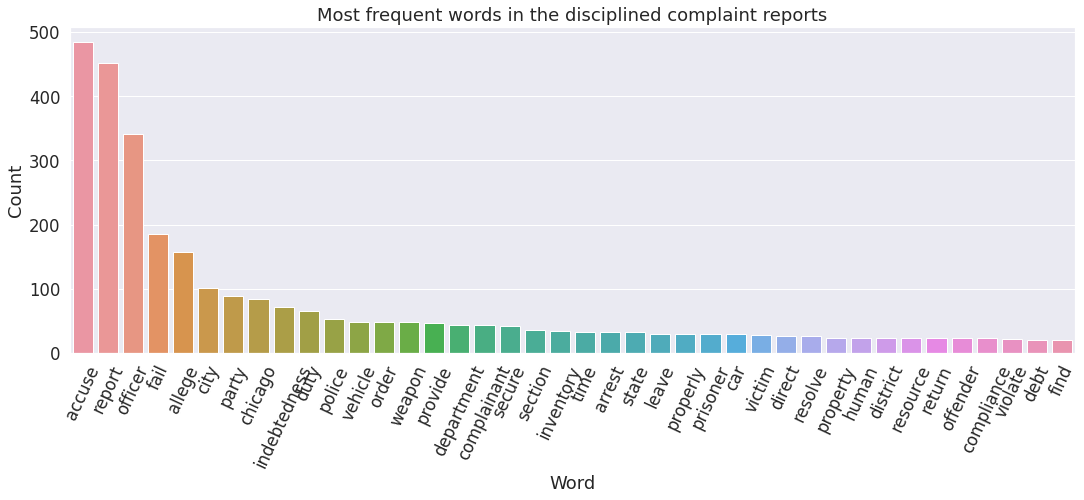

In [ ]:
plot_word_count_bar_chart(words_dict_disciplined, num_of_words=40, type_of_report='disciplined')

After going through the above word count bar chart, we can create some additional custom stop words prior to topic modeling. We already know that these are complaint reports on Chicago police officers. so, words such as accuse, report, officer, allege, chicago, police can be added to the stop words list

In [ ]:
custom_stop_words = ["accuse", "report", "officer", "allege", "city", "chicago", "police"]

let us recreate the corpus again

In [ ]:
corpus_disciplined, words_dict_disciplined = create_complaint_corpus(complaint_narrative_disciplined, custom_stop_words)

In [ ]:
len(corpus_disciplined)

378

let us relook at the corpus sample once again


In [ ]:
for cur_corpus in corpus_disciplined[0:5]:
  print(cur_corpus)
  print('==============================================')

['inattentative', 'duty', 'fail', 'properly', 'search', 'prisoner', 'property', 'bag', 'pack', 'result', 'retrieve', 'bag', 'green', 'leafy', 'substance', 'suspect', 'cannabis', 'inventorie', 'time', 'inattentative', 'duty', 'fail', 'properly', 'search', 'prisoner', 'property', 'bag', 'pack', 'result', 'retrieve', 'bag', 'green', 'leafy', 'substance', 'suspect', 'cannabis', 'inventorie', 'time']
['submit', 'false', 'identify', 'participate', 'arrest', 'identify', 'arrest', 'second', 'arrest', 'submit', 'false', 'identify', 'participate', 'arrest', 'identify', 'arrest', 'second', 'arrest']
['fail', 'provide', 'department', 'current', 'address']
['sign', 'radio', 'leave', 'partner', 'today', 'date', 'able', 'locate', 'radio']
['inattentive', 'duty', 'fail', 'properly', 'secure', 'weapon', 'go', 'fitting', 'room', 'carson', 'pirie', 'scott', 'leave', 'duty', 'weapon', 'fitting', 'room', 'weapon', 'recover', 'hammond', 'department']


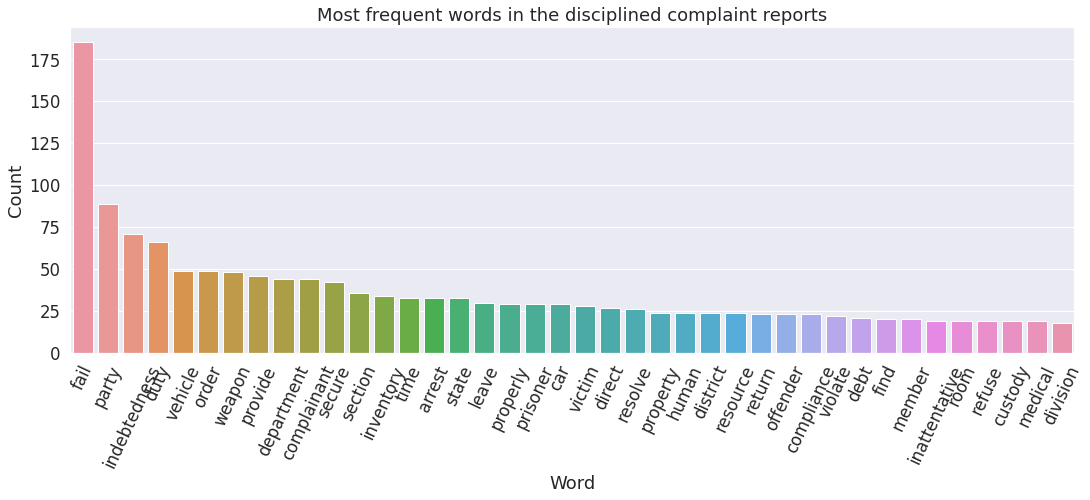

In [ ]:
plot_word_count_bar_chart(words_dict_disciplined, num_of_words=40, type_of_report='disciplined')

In [ ]:
bigram_disciplined = gensim.models.Phrases(corpus_disciplined)

In [ ]:
corpus_disciplined_with_bigram = [bigram_disciplined[cur_complaint] for cur_complaint in corpus_disciplined]

In [ ]:
corpus_disciplined_with_bigram[300]

['fail_secure', 'weapon', 'inside', 'residence']

In [ ]:
corpus_disciplined[300]

['fail', 'secure', 'weapon', 'inside', 'residence']

In [ ]:
dictionary_disciplined = Dictionary(corpus_disciplined_with_bigram)
print(dictionary_disciplined)

Dictionary(1341 unique tokens: ['bag', 'cannabis', 'fail_properly', 'green', 'inattentative_duty']...)


In [ ]:
corpus_disciplined_for_topic_model = [dictionary_disciplined.doc2bow(cur_complaint) for cur_complaint in corpus_disciplined_with_bigram]

In [ ]:
corpus_disciplined_for_topic_model[2]

[(22, 1), (23, 1), (24, 1), (25, 1)]

We will start with Hierarchical Dirichlet Process (HDP) Topic Modelling Algorithm, we don't have to specify the number of topics here, the algorithm will find out the best value for number of topics.

In [ ]:
hdpModel_disciplined = HdpModel(corpus=corpus_disciplined_for_topic_model, id2word=dictionary_disciplined)

In [ ]:
len(hdpModel_disciplined.show_topics())

20

In [ ]:
hdpModel_disciplined.show_topics()

[(0,
  '0.004*text + 0.004*contraband + 0.004*october + 0.004*district_station + 0.004*answer + 0.004*vand + 0.004*harass + 0.003*pd + 0.003*file + 0.003*walbum + 0.003*x00105792 + 0.003*damage + 0.003*equipment + 0.003*revenue + 0.003*inattention + 0.003*remain + 0.003*argumentative + 0.003*concern + 0.003*street + 0.003*charger'),
 (1,
  '0.006*request + 0.005*worth + 0.005*wall + 0.004*anymore + 0.004*isssue + 0.004*person + 0.004*facebook + 0.004*3c + 0.004*arterio + 0.004*resolve + 0.004*vernetta + 0.004*475.00- + 0.004*discourteous + 0.004*observe + 0.003*employee + 0.003*harass + 0.003*brief + 0.003*subsequently + 0.003*vice + 0.003*cpd'),
 (2,
  '0.005*iv + 0.005*aco + 0.005*party + 0.005*walbum + 0.005*interview + 0.005*ken + 0.005*betore + 0.004*task + 0.004*hit + 0.004*eugene + 0.004*spann + 0.004*performance + 0.004*investigation + 0.004*nextel + 0.004*point + 0.004*parking + 0.004*deodorant + 0.003*tule_disobedient + 0.003*paper + 0.003*house'),
 (3,
  '0.005*handicap + 0.

In [ ]:
hdp_coherence_model_disciplined = CoherenceModel(model=hdpModel_disciplined, texts=corpus_disciplined_with_bigram, dictionary=dictionary_disciplined, coherence='c_v')
hdp_coherence_disciplined = hdp_coherence_model_disciplined.get_coherence()
hdp_coherence_disciplined

0.7805017723461112

Next, we are going to try with Latent Semantic Indexing (LSI) model, here we need to pass the number of topics, based on the coherence score we can figure out the best "number of topics"

In [ ]:
best_lsiModel_disciplined = None
best_coherence_val = 0
for num_topics in [3, 5, 8, 10, 15, 20, 25, 30]:
    lsiModel = LsiModel(corpus=corpus_disciplined_for_topic_model, num_topics=num_topics, id2word=dictionary_disciplined)
    coherenceModel = CoherenceModel(model=lsiModel, texts=corpus_disciplined_with_bigram, dictionary=dictionary_disciplined, coherence='c_v')
    coherence_val = coherenceModel.get_coherence()
    print('Number of Topics', num_topics)
    print('Coherence Value', coherence_val)
    if coherence_val > best_coherence_val:
      best_coherence_val = coherence_val
      best_lsiModel_disciplined = lsiModel

Number of Topics 3
Coherence Value 0.42058341603667043
Number of Topics 5
Coherence Value 0.612993363009684
Number of Topics 8
Coherence Value 0.5473265481695828
Number of Topics 10
Coherence Value 0.4545004261863248
Number of Topics 15
Coherence Value 0.47626781301862303
Number of Topics 20
Coherence Value 0.4722749759637642
Number of Topics 25
Coherence Value 0.4648218864166996
Number of Topics 30
Coherence Value 0.46258726913237774


In [ ]:
len(best_lsiModel_disciplined.show_topics())

5

In [ ]:
best_lsiModel_disciplined.show_topics()

[(0,
  '-0.716*"party" + -0.189*"fail" + -0.150*"complaint" + -0.145*"victim" + -0.128*"state" + -0.125*"inventory" + -0.116*"garage" + -0.115*"mail" + -0.113*"take" + -0.108*"vehicle"'),
 (1,
  '-0.592*"inventory" + -0.275*"time" + 0.241*"party" + -0.218*"count" + -0.207*"arrestee" + -0.169*"inventorie" + -0.166*"fail" + -0.161*"inattentive_duty" + -0.155*"fail_properly" + -0.137*"money"'),
 (2,
  '0.558*"offender" + 0.347*"seat" + 0.208*"flee" + 0.205*"handcuff" + 0.199*"vehicle" + 0.195*"custody" + 0.194*"transport" + 0.184*"chase" + 0.166*"processing" + 0.165*"foot"'),
 (3,
  '0.545*"arrestee" + 0.337*"fail_properly" + 0.295*"inattentive_duty" + 0.293*"result" + 0.292*"secure" + 0.265*"escape_custody" + -0.229*"inventory" + -0.189*"time" + -0.174*"count" + 0.104*"prisoner"'),
 (4,
  '0.401*"fail" + 0.386*"complainant" + 0.181*"leave" + -0.180*"party" + 0.170*"fail_provide" + 0.147*"state" + 0.141*"nellum" + -0.133*"inventory" + 0.115*"request" + 0.112*"refuse"')]

Next, we are going to try with Latent Dirichlet Allocation (LDA) model, here we need to pass the number of topics, based on the coherence score we can figure out the best "number of topics"

In [ ]:
best_ldaModel_disciplined = None
best_coherence_val = 0
for num_topics in [3, 5, 8, 10, 15, 20, 25, 30]:

  ldaModel = LdaModel(corpus=corpus_disciplined_for_topic_model, num_topics=num_topics, id2word=dictionary_disciplined)
  coherenceModel = CoherenceModel(model=ldaModel, texts=corpus_disciplined_with_bigram, dictionary=dictionary_disciplined, coherence='c_v')
  coherence_val = coherenceModel.get_coherence()
  print('Number of Topics', num_topics)
  print('Coherence Value', coherence_val)
  if coherence_val > best_coherence_val:
    best_coherence_val = coherence_val
    best_ldaModel_disciplined = ldaModel

Number of Topics 3
Coherence Value 0.4268679463324514
Number of Topics 5
Coherence Value 0.43766769271228584
Number of Topics 8
Coherence Value 0.48298388843518814
Number of Topics 10
Coherence Value 0.45946831483450123
Number of Topics 15
Coherence Value 0.4307386436296576
Number of Topics 20
Coherence Value 0.42732928784992746
Number of Topics 25
Coherence Value 0.4366236428849735
Number of Topics 30
Coherence Value 0.4404924329111391


In [ ]:
len(best_ldaModel_disciplined.show_topics())

8

In [ ]:
best_ldaModel_disciplined.show_topics()

[(0,
  '0.035*"party" + 0.015*"fail" + 0.011*"complaint" + 0.010*"victim" + 0.010*"weapon" + 0.009*"indebtedness" + 0.009*"violate" + 0.008*"vehicle" + 0.008*"duty" + 0.008*"debt"'),
 (1,
  '0.019*"party" + 0.015*"department" + 0.010*"prisoner" + 0.010*"witness" + 0.008*"assign" + 0.008*"transport" + 0.008*"vehicle" + 0.008*"take" + 0.007*"post" + 0.007*"public"'),
 (2,
  '0.032*"fail" + 0.018*"arrest" + 0.016*"fail_provide" + 0.015*"resolve_indebtedness" + 0.013*"date_question" + 0.013*"debt_human" + 0.013*"administration_require" + 0.013*"resource_division" + 0.013*"receive_notice" + 0.013*"proof_resolve"'),
 (3,
  '0.032*"fail" + 0.016*"party" + 0.014*"vehicle" + 0.014*"offender" + 0.010*"department" + 0.010*"complainant" + 0.009*"arrest" + 0.009*"time" + 0.009*"find" + 0.007*"car"'),
 (4,
  '0.027*"weapon" + 0.024*"indebtness" + 0.012*"complainant" + 0.011*"fail" + 0.010*"state" + 0.010*"incident" + 0.010*"sustain" + 0.009*"return" + 0.008*"medical" + 0.008*"duty"'),
 (5,
  '0.019*

Next we are going to use the pyLDAvis package to visualize the best LDA model results

In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(best_ldaModel_disciplined, corpus_disciplined_for_topic_model, dictionary_disciplined)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.040093  0.035214       1        1  15.966771
0     -0.036463 -0.075713       2        1  15.077789
6     -0.082328 -0.040955       3        1  14.213726
7      0.061363  0.136521       4        1  13.654066
5      0.139496 -0.029648       5        1  13.331874
2     -0.153207  0.069513       6        1  11.474966
4      0.004387 -0.062627       7        1   9.806858
1      0.026657 -0.032306       8        1   6.473952, topic_info=             Term       Freq      Total Category  logprob  loglift
965  indebtedness  38.000000  38.000000  Default  30.0000  30.0000
968    indebtness  12.000000  12.000000  Default  29.0000  29.0000
45         weapon  35.000000  35.000000  Default  28.0000  28.0000
8        prisoner  22.000000  22.000000  Default  27.0000  27.0000
48          party  71.000000  71.000000  Default  26.0000  26.0000
..            ...        ...        ...      ...      ...      ...
310   complainant   1.986784  34.581314   Topic8  -4.9977  -0.1194
123        victim   1.716068  22.847197   Topic8  -5.1441   0.1486
62      complaint   1.453322  13.797570   Topic8  -5.3103   0.4867
46           fail   1.448478  82.691893   Topic8  -5.3137  -1.3072
260      incident   1.362994  13.356361   Topic8  -5.3745   0.4551

[510 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
732       8  0.711909  007th
402       1  0.520103     1s
402       3  0.130026     1s
402       6  0.130026     1s
392       5  0.774545    2nd
...     ...       ...    ...
479       6  0.460808   word
210       1  0.171366   work
210       5  0.171366   work
210       6  0.342733   work
210       7  0.342733   work

[949 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 7, 8, 6, 3, 5, 2])

In [ ]:
best_ldaModel_disciplined.save("/content/drive/MyDrive/DSS_CP5/best_ldaModel_disciplined.model")

In [ ]:
best_lsiModel_disciplined.save("/content/drive/MyDrive/DSS_CP5/best_lsiModel_disciplined.model")

In [ ]:
hdpModel_disciplined.save("/content/drive/MyDrive/DSS_CP5/hdpModel_disciplined.model")

In [ ]:
#loaded_ldaModel_disciplined = LdaModel.load("/content/drive/MyDrive/DSS_CP5/best_ldaModel_disciplined.model")

In [ ]:
#pyLDAvis.gensim_models.prepare(loaded_ldaModel_disciplined, corpus_disciplined_for_topic_model, dictionary_disciplined)

Let us analyze the complaint reports where the officers were not disciplined

In [9]:
df_not_disciplined = pd.read_csv("/content/drive/MyDrive/DSS_CP5/data_cp5_not_disciplined.csv")
df_not_disciplined.head()

,crid,incident_year,is_officer_complaint,cr_text,category,allegation_name,text_content,complaint_narrative,officer_id,disciplined,gender,race,rank,current_salary,allegation_count,discipline_count,honorable_mention_count,major_award_count,civilian_compliment_count
0,1048977,2011,True,Initial / Intake Allegation 1: The reporting p...,Traffic,Miscellaneous,FACE SHEET (Notification Date: 02-OCT-2011 - L...,The reporting party alleges that a male\nHispa...,25299,False,M,Hispanic,Police Officer,96060.0,63,10,10,0,1
1,1049373,2011,False,Initial / Intake Allegation 1: THE REPORTING P...,Verbal Abuse,"Racial / Ethnic, Etc.",AUTO CR - LOG SUMMARY #1049373\n\nTYPE: CR\n\n...,Itis alleged that the accused directed a racia...,3055,False,M,Black,Sergeant of Police,107988.0,67,1,24,0,2
2,1049373,2011,False,Initial / Intake Allegation 1: THE REPORTING P...,Verbal Abuse,"Racial / Ethnic, Etc.",AUTO CR - LOG SUMMARY #1049373\n\nTYPE: CR\n\n...,NOT SUSTAINED,3055,False,M,Black,Sergeant of Police,107988.0,67,1,24,0,2
3,1049373,2011,False,Initial / Intake Allegation 1: THE REPORTING P...,Verbal Abuse,"Racial / Ethnic, Etc.",AUTO CR - LOG SUMMARY #1049373\n\nTYPE: CR\n\n...,THE REPORTING PARTY STATES THAT\nHE ASKED THE ...,3055,False,M,Black,Sergeant of Police,107988.0,67,1,24,0,2
4,1049557,2011,False,Initial / Intake Allegation 1: The reporting p...,Illegal Search,Improper Search Of Vehicle,AUTO CR - LOG SUMMARY #1049557\n\nTYPE: INFO\n...,(None Entered),19329,False,M,White,Police Officer,90024.0,44,1,56,1,2


In [10]:
df_not_disciplined.shape

(26560, 19)

In [11]:
df_not_disciplined["crid"].nunique()

4426

In [12]:
df_not_disciplined_fil = df_not_disciplined.drop_duplicates(subset=['crid'])
df_not_disciplined_fil.shape

(4426, 19)

There are instances in a complaint report where all the accused officers are not disciplined. For example, let's say in a particular complaint report, 10 officers are accused, but at the end of the day 7 are disciplined and the remaining 3 are not. We are going to filter out these type of reports from the "not disciplined" reports as they have been already accounted for in the disciplined reports section and might not give an accurate representation in the topic modeling results of "not disciplined" reports

In [13]:
crid_disciplined = df_disciplined_fil["crid"].tolist()
len(crid_disciplined)

392

In [14]:
df_not_disciplined_fil = df_not_disciplined_fil[~df_not_disciplined_fil['crid'].isin(crid_disciplined)]
df_not_disciplined_fil.shape

(4393, 19)

In [ ]:
#df_not_disciplined_fil.head()

In [ ]:
df_not_disciplined_fil["complaint_narrative"].isna().sum()

0

In [ ]:
complaint_narrative_not_disciplined = df_not_disciplined_fil["complaint_narrative"].tolist()
len(complaint_narrative_not_disciplined)

4393

let us look at sample complaint reports for not disciplined


In [ ]:
for complaint in complaint_narrative_not_disciplined[0:5]:
  print(complaint)
  print("====================")

The reporting party alleges that a male
Hispanic uniformed officer, possibly named
“Sanchez" detained and directed profanities
towards him while inquiring about an F.O.P.
medallion on his personal vehicle, during a
traffic stop. The reporting party alleges that
the officer stated in an aggressive manner,
“You dumb ass, go fuck yourself, your
mom'’s a bitch!"
Itis alleged that the accused directed a racial slur toward the complainant,
It is alleged that the accused directed various profanities toward the
complainant
It is alleged that the accused threatened to "bust" the complainant's head.
(None Entered)
(None Entered)
CONFIDENTIAL


In [ ]:
df_not_disciplined_fil["complaint_narrative"].value_counts()[:20]

(None Entered)                                                                                                                                                                                                                      756
Confidential                                                                                                                                                                                                                         13
NO AFFIDAVIT                                                                                                                                                                                                                         13
confidential investigation                                                                                                                                                                                                            7
CONFIDENTIAL                                                            

we have to do further filtering, as values such as None Entered, Confidential, etc. don't add any value

In [15]:
content_to_filter = ["(none entered)", "confidential", "confidential investigation", "=confidential", '"confidential"', "not sustained", "unknown"]

In [16]:
df_not_disciplined_fil = df_not_disciplined_fil[~df_not_disciplined_fil['complaint_narrative'].str.lower().isin(content_to_filter)]
df_not_disciplined_fil.shape

(3587, 19)

In [ ]:
df_not_disciplined_fil["complaint_narrative"].value_counts()[:20]

NO AFFIDAVIT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              13
 Confidential                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

we need to some additional filtering

In [17]:
content_to_filter2 = ["no affidavit", " confidential", "}=confidential", "unfounded"]

final check after filtering

In [18]:
df_not_disciplined_fil = df_not_disciplined_fil[~df_not_disciplined_fil['complaint_narrative'].str.lower().isin(content_to_filter2)]
df_not_disciplined_fil.shape

(3563, 19)

In [ ]:
df_not_disciplined_fil["complaint_narrative"].value_counts()[:20]

It is reported that the accused officer, after\nbeing notified of indebtedness to the city,\nfailed to provide documentation of his\ncompliance.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   5
THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED OFFICER ARRESTED\nHIM WITHOUT JUSTIFICATION.                                                                                                                                                                         

Let us look at some of the type of complaint categories and allegation names, this will help us later in understanding how similar the topic modeling results are with respect to the actual categories and allegation names

In [19]:
df_not_disciplined_fil["category"].value_counts()

Operation/Personnel Violations    1455
Illegal Search                     707
False Arrest                       401
Lockup Procedures                  317
Use Of Force                       229
Traffic                            148
Conduct Unbecoming (Off-Duty)      123
Domestic                            69
Verbal Abuse                        45
Bribery / Official Corruption       17
Supervisory Responsibilities        17
Drug / Alcohol Abuse                17
Criminal Misconduct                 16
First Amendment                      2
Name: category, dtype: int64

In [22]:
df_not_disciplined_fil["allegation_name"].value_counts()[0:40]

Inadequate / Failure To Provide Service                    851
Illegal Arrest / False Arrest                              401
Improper Search Of Vehicle                                 375
Miscellaneous                                              286
Prisoners Property                                         244
Improper Search Of Person                                  191
Neglect Of Duty                                            165
Search Of Premise Without Warrant                          141
Excessive Force / On Duty - Injury                          87
Slow / No Response                                          71
Improper Processing / Reporting / Procedures                58
Association With Felon                                      47
Inventory Procedures                                        42
Domestic Altercation - Physical Abuse                       37
Indebtedness To City                                        36
Excessive Force / On Duty - No Injury                  

In [ ]:
complaint_narrative_not_disciplined = df_not_disciplined_fil["complaint_narrative"].tolist()
len(complaint_narrative_not_disciplined)

3563

In [ ]:
corpus_not_disciplined, words_dict_not_disciplined = create_complaint_corpus(complaint_narrative_not_disciplined, custom_stop_words)

In [ ]:
len(corpus_not_disciplined)

3561

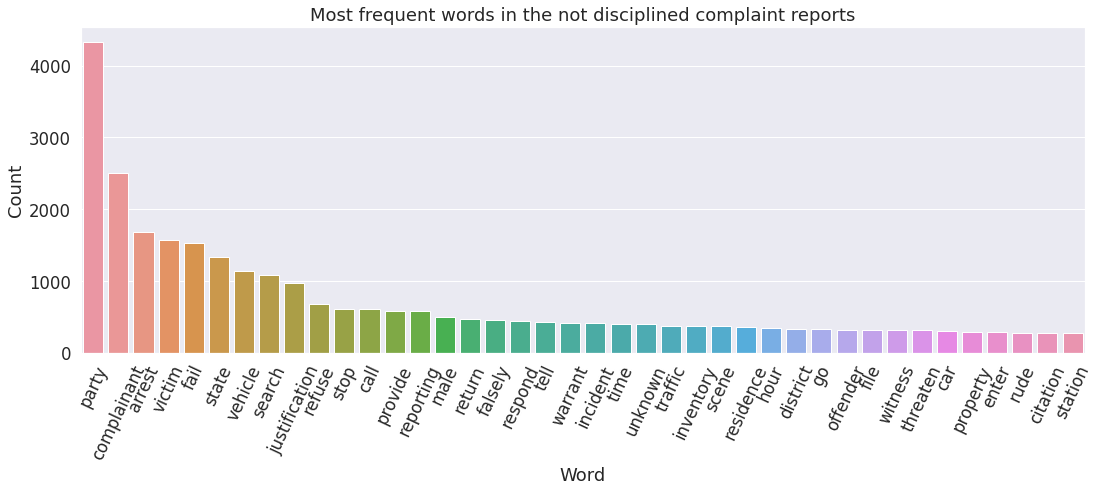

In [ ]:
plot_word_count_bar_chart(words_dict_not_disciplined, num_of_words=40, type_of_report='not disciplined')

After going through the above word count bar chart, we can create some additional custom stop words prior to topic modeling. We already know that these are complaint reports on Chicago police officers. so, words such as party, complainant, victim, provide,  can be added to the stop words list

In [ ]:
custom_stop_words2 = ["party", "complainant", "victim", "provide"]

In [ ]:
corpus_not_disciplined, words_dict_not_disciplined = create_complaint_corpus(complaint_narrative_not_disciplined, custom_stop_words + custom_stop_words2)

In [ ]:
len(corpus_not_disciplined)

3561

Let us check the word count bar chart again

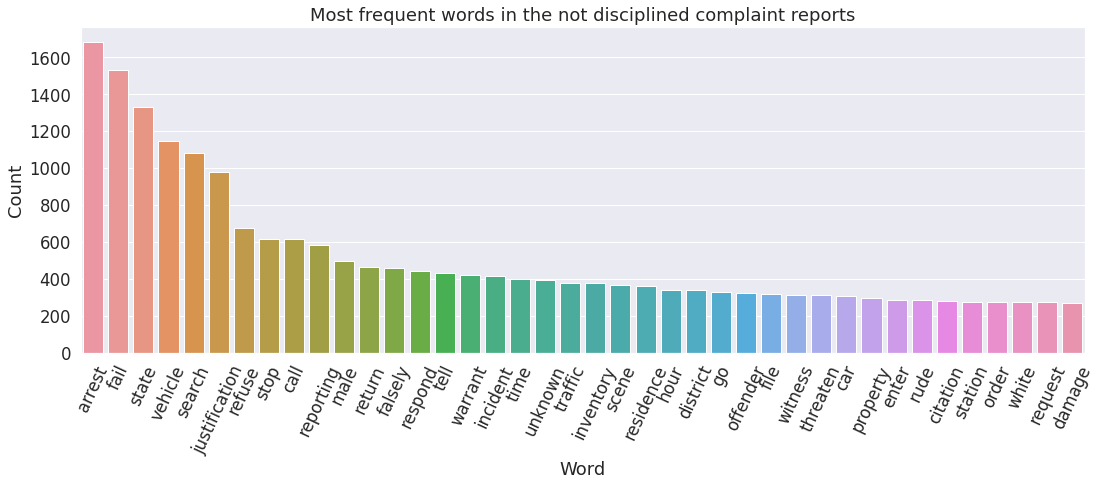

In [ ]:
plot_word_count_bar_chart(words_dict_not_disciplined, num_of_words=40, type_of_report='not disciplined')

In [ ]:
bigram_not_disciplined = gensim.models.Phrases(corpus_not_disciplined)

In [ ]:
corpus_not_disciplined_with_bigram = [bigram_not_disciplined[cur_complaint] for cur_complaint in corpus_not_disciplined]

In [ ]:
len(corpus_not_disciplined_with_bigram)

3561

In [ ]:
dictionary_not_disciplined = Dictionary(corpus_not_disciplined_with_bigram)
print(dictionary_not_disciplined)

Dictionary(6296 unique tokens: ['ass', 'bitch', 'detain', 'direct_profanity', 'dumb']...)


In [ ]:
corpus_not_disciplined_for_topic_model = [dictionary_not_disciplined.doc2bow(cur_complaint) for cur_complaint in corpus_not_disciplined_with_bigram]

In [ ]:
len(corpus_not_disciplined_for_topic_model)

3561

We will start with Hierarchical Dirichlet Process (HDP) Topic Modelling Algorithm, we don't have to specify the number of topics here, the algorithm will find out the best value for number of topics.

In [ ]:
hdpModel_not_disciplined = HdpModel(corpus=corpus_not_disciplined_for_topic_model, id2word=dictionary_not_disciplined)

In [ ]:
len(hdpModel_not_disciplined.show_topics())

20

In [ ]:
hdpModel_not_disciplined.show_topics()

[(0,
  '0.012*state + 0.011*vehicle + 0.009*arrest + 0.009*fail + 0.006*reporting + 0.006*call + 0.006*justification + 0.005*search + 0.004*unknown + 0.004*refuse + 0.004*tell + 0.003*sergeant + 0.003*respond + 0.003*stop + 0.003*threaten + 0.003*go + 0.003*time + 0.003*drive + 0.002*residence + 0.002*car'),
 (1,
  '0.005*state + 0.004*arrest + 0.003*fail + 0.003*reporting + 0.002*justification + 0.002*call + 0.002*refuse + 0.002*vehicle + 0.002*female + 0.001*tell + 0.001*son + 0.001*search + 0.001*file + 0.001*offender + 0.001*time + 0.001*incident + 0.001*surgery + 0.001*go + 0.001*stop + 0.001*minor'),
 (2,
  '0.004*state + 0.004*fail + 0.003*arrest + 0.003*search + 0.003*justification + 0.003*vehicle + 0.002*reporting + 0.002*call + 0.002*refuse + 0.001*case + 0.001*stabber + 0.001*consent + 0.001*name + 0.001*victm + 0.001*transport + 0.001*threaten + 0.001*tell + 0.001*handcuff + 0.001*time + 0.001*damage'),
 (3,
  '0.005*state + 0.005*arrest + 0.005*fail + 0.003*justification +

In [ ]:
hdpModel_not_disciplined.save("/content/drive/MyDrive/DSS_CP5/hdpModel_not_disciplined.model")

In [ ]:
hdp_coherence_model_not_disciplined = CoherenceModel(model=hdpModel_not_disciplined, texts=corpus_not_disciplined_with_bigram, dictionary=dictionary_not_disciplined, coherence='c_v')
hdp_coherence_not_disciplined = hdp_coherence_model_not_disciplined.get_coherence()
hdp_coherence_not_disciplined

0.6952389255744597

Next, we are going to try with Latent Semantic Indexing (LSI) model, here we need to pass the number of topics, based on the coherence score we can figure out the best "number of topics"

In [ ]:
best_lsiModel_not_disciplined = None
best_coherence_val = 0
for num_topics in [3, 5, 8, 10, 15, 20, 25, 30]:
    lsiModel = LsiModel(corpus=corpus_not_disciplined_for_topic_model, num_topics=num_topics, id2word=dictionary_not_disciplined)
    coherenceModel = CoherenceModel(model=lsiModel, texts=corpus_not_disciplined_with_bigram, dictionary=dictionary_not_disciplined, coherence='c_v')
    coherence_val = coherenceModel.get_coherence()
    print('Number of Topics', num_topics)
    print('Coherence Value', coherence_val)
    if coherence_val > best_coherence_val:
      best_coherence_val = coherence_val
      best_lsiModel_not_disciplined = lsiModel

Number of Topics 3
Coherence Value 0.42408292948574555
Number of Topics 5
Coherence Value 0.3548549549250428
Number of Topics 8
Coherence Value 0.29212784972623573
Number of Topics 10
Coherence Value 0.46276088492198203
Number of Topics 15
Coherence Value 0.3535832405516025
Number of Topics 20
Coherence Value 0.377182396094469
Number of Topics 25
Coherence Value 0.39473001163982474
Number of Topics 30
Coherence Value 0.34669635332240606


In [ ]:
len(best_lsiModel_not_disciplined.show_topics())

10

In [ ]:
best_lsiModel_not_disciplined.show_topics()

[(0,
  '-0.430*"state" + -0.369*"arrest" + -0.353*"vehicle" + -0.299*"fail" + -0.299*"justification" + -0.247*"search" + -0.200*"reporting" + -0.141*"call" + -0.116*"stop" + -0.100*"refuse"'),
 (1,
  '0.487*"justification" + -0.394*"state" + 0.382*"search" + -0.349*"fail" + 0.308*"vehicle" + -0.197*"call" + 0.122*"stop" + 0.118*"search_warrant" + -0.110*"refuse" + -0.106*"reporting"'),
 (2,
  '-0.564*"arrest" + 0.473*"vehicle" + 0.367*"state" + -0.336*"fail" + -0.149*"justification" + -0.112*"offender" + 0.111*"car" + -0.102*"search_warrant" + 0.100*"reporting" + -0.098*"hour"'),
 (3,
  '0.673*"search_warrant" + 0.230*"hour" + -0.227*"justification" + -0.223*"arrest" + 0.162*"november" + 0.141*"home" + 0.129*"itis_serve" + 0.125*"incident_document" + 0.124*"jul_approximately" + 0.119*"warrant"'),
 (4,
  '-0.540*"fail" + -0.507*"vehicle" + 0.391*"state" + 0.332*"justification" + 0.121*"arrest" + -0.079*"search" + 0.076*"tell" + -0.075*"lieutenant_mccartney" + -0.074*"proper" + 0.072*"ca

In [ ]:
best_lsiModel_not_disciplined.save("/content/drive/MyDrive/DSS_CP5/best_lsiModel_not_disciplined.model")

Next, we are going to try with Latent Dirichlet Allocation (LDA) model, here we need to pass the number of topics, based on the coherence score we can figure out the best "number of topics"

In [ ]:
best_ldaModel_not_disciplined = None
best_coherence_val = 0
for num_topics in [3, 5, 8, 10, 15, 20, 25, 30]:

  ldaModel = LdaModel(corpus=corpus_not_disciplined_for_topic_model, num_topics=num_topics, id2word=dictionary_not_disciplined)
  coherenceModel = CoherenceModel(model=ldaModel, texts=corpus_not_disciplined_with_bigram, dictionary=dictionary_not_disciplined, coherence='c_v')
  coherence_val = coherenceModel.get_coherence()
  print('Number of Topics', num_topics)
  print('Coherence Value', coherence_val)
  if coherence_val > best_coherence_val:
    best_coherence_val = coherence_val
    best_ldaModel_not_disciplined = ldaModel

Number of Topics 3
Coherence Value 0.29115618511805746
Number of Topics 5
Coherence Value 0.28975592116866883
Number of Topics 8
Coherence Value 0.31118296121134487
Number of Topics 10
Coherence Value 0.30413013240575937
Number of Topics 15
Coherence Value 0.37075487774514165
Number of Topics 20
Coherence Value 0.35454293159642114
Number of Topics 25
Coherence Value 0.35236684603143303
Number of Topics 30
Coherence Value 0.3604323708946115


In [ ]:
best_ldaModel_not_disciplined.show_topics(15)

[(0,
  '0.020*"fail" + 0.017*"reporting" + 0.016*"file" + 0.016*"call" + 0.016*"state" + 0.015*"arrest" + 0.014*"refuse" + 0.010*"justification" + 0.009*"respond" + 0.009*"allow"'),
 (1,
  '0.039*"vehicle" + 0.032*"state" + 0.015*"fail" + 0.015*"arrest" + 0.013*"reporting" + 0.013*"search" + 0.012*"justification" + 0.011*"tell" + 0.007*"call" + 0.007*"return"'),
 (2,
  '0.053*"justification" + 0.049*"arrest" + 0.020*"stop" + 0.017*"search" + 0.014*"state" + 0.014*"refuse" + 0.014*"sergeant" + 0.012*"fail" + 0.012*"tell" + 0.009*"threaten"'),
 (3,
  '0.034*"falsely_arrest" + 0.027*"vehicle" + 0.021*"arrest" + 0.021*"fail" + 0.020*"unknown" + 0.010*"refuse" + 0.009*"state" + 0.008*"residence" + 0.008*"drive" + 0.008*"department_member"'),
 (4,
  '0.021*"reporting" + 0.016*"arrest" + 0.015*"warrant" + 0.015*"search" + 0.013*"probable_cause" + 0.012*"fail" + 0.011*"plaintiff" + 0.010*"state" + 0.009*"stop" + 0.008*"usc"'),
 (5,
  '0.022*"state" + 0.020*"fail" + 0.011*"arrest" + 0.010*"repo

In [ ]:
pyLDAvis.gensim_models.prepare(best_ldaModel_not_disciplined, corpus_not_disciplined_for_topic_model, dictionary_not_disciplined)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.010762 -0.034205       1        1  11.845325
9     -0.030647 -0.121700       2        1   7.833931
2      0.034776  0.057776       3        1   7.757928
3      0.001140  0.011564       4        1   7.445603
6     -0.098749 -0.009848       5        1   7.136014
8     -0.023340  0.059135       6        1   7.061097
10    -0.058789  0.091266       7        1   6.388003
7      0.017339  0.058900       8        1   6.348596
0     -0.037538  0.038914       9        1   6.284528
13     0.154098  0.010789      10        1   6.217531
14     0.021174  0.079431      11        1   5.980125
11    -0.061854 -0.018348      12        1   5.262208
4      0.028665 -0.087046      13        1   5.088221
5     -0.101359 -0.075556      14        1   4.823180
12     0.144322 -0.061070      15        1   4.527709, topic_info=               Term         Freq        Total Category  logprob  loglift
58    justification   878.000000   878.000000  Default  30.0000  30.0000
18          vehicle   882.000000   882.000000  Default  29.0000  29.0000
255          search   659.000000   659.000000  Default  28.0000  28.0000
57           arrest  1159.000000  1159.000000  Default  27.0000  27.0000
81   falsely_arrest   344.000000   344.000000  Default  26.0000  26.0000
..              ...          ...          ...      ...      ...      ...
50            state    18.134440  1182.753153  Topic15  -4.9960  -1.0828
123  fail_inventory    12.899202   203.362137  Topic15  -5.3367   0.3371
13         personal    11.068393    90.561803  Topic15  -5.4897   0.9930
709            male    11.066399   123.125556  Topic15  -5.4899   0.6857
46        reporting    11.031805   556.246249  Topic15  -5.4930  -0.8255

[1126 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
2503     14  0.833888  009th_district
3139      2  0.923517  010th_district
3172     10  0.775188           011th
1585     11  0.118087  014th_district
1585     12  0.826611  014th_district
...     ...       ...             ...
2347      9  0.464904           young
2347     12  0.066415           young
2347     13  0.066415           young
2347     14  0.132830           young
2377     10  0.713622          |-bond

[3621 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 10, 3, 4, 7, 9, 11, 8, 1, 14, 15, 12, 5, 6, 13])

In [ ]:
best_ldaModel_not_disciplined.save("/content/drive/MyDrive/DSS_CP5/best_ldaModel_not_disciplined.model")

In [ ]:
#loaded_ldaModel_not_disciplined = LdaModel.load("/content/drive/MyDrive/DSS_CP5/best_ldaModel_not_disciplined.model")

In [ ]:
#pyLDAvis.gensim_models.prepare(loaded_ldaModel_not_disciplined, corpus_not_disciplined_for_topic_model, dictionary_not_disciplined)